In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from  torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# параметры распределений
mu0, sigma0 = [-2., 1.],[[1,0.5],[0.5,1]]
mu1, sigma1 = [3., 2.], [[1,0.5],[0.5,1]]

In [3]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [4]:
d0 = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([mu0]), torch.tensor([sigma0]))
d1 = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([mu1]),torch.tensor([sigma1]))

In [6]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([ 0.1629, -0.3452]), tensor(-0.5778)]


In [7]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = F.sigmoid(layer(x.view(-1, 2)))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = F.sigmoid(layer(x.view(-1, 2)))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_opt.step()

Ошибка после 0 итераций: 0.712903
Ошибка после 1 итераций: 0.269126
Ошибка после 2 итераций: 0.176335
Ошибка после 3 итераций: 0.139188
Ошибка после 4 итераций: 0.117748
Ошибка после 5 итераций: 0.104205
Ошибка после 6 итераций: 0.094004
Ошибка после 7 итераций: 0.086701
Ошибка после 8 итераций: 0.080841
Ошибка после 9 итераций: 0.075704
Ошибка после 10 итераций: 0.072131
Ошибка после 11 итераций: 0.068150
Ошибка после 12 итераций: 0.064865
Ошибка после 13 итераций: 0.062790
Ошибка после 14 итераций: 0.059879
Ошибка после 15 итераций: 0.057740
Ошибка после 16 итераций: 0.056506
Ошибка после 17 итераций: 0.054518
Ошибка после 18 итераций: 0.052793
Ошибка после 19 итераций: 0.051445


In [26]:
import numpy as np
x, y = np.meshgrid( np.linspace(-10, 10, 500),  np.linspace(-10, 10, 500))
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
d0_pdf = stats.multivariate_normal.pdf(pos, mu0, sigma0)
d1_pdf = stats.multivariate_normal.pdf(pos, mu1, sigma1)

XY = np.c_[x.ravel(), x.ravel()]
XY_tensor = torch.tensor(XY, dtype=torch.float)
x_tensor = torch.tensor(XY, dtype=torch.float)
with torch.no_grad():
    dist = F.sigmoid(layer(x_tensor.view(-1, 2))).numpy()
dist =dist.reshape(x.shape)

In [9]:
ratio = d1_pdf / (d1_pdf + d0_pdf)

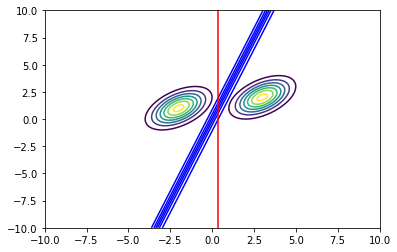

In [32]:
fig, ax = plt.subplots()
d0_ctr = ax.contour(x, y,d0_pdf)
d1_ctr  = ax.contour(x, y,d1_pdf)
ratio  = ax.contour(x, y,ratio, colors='blue')
contour_sigmoid = ax.contour(x, y, dist, levels=[0, 0.5, 1], colors='red')

In [15]:
print([p.data[0] for p in layer.parameters()])

[tensor([ 1.6870, -0.1144]), tensor(-0.5140)]


## Код для отрисовки из слака:

In [58]:
import matplotlib.patches as mpatches
def prepare_plot_params(F):
    plot_params = {}

    x_scale = np.linspace(-5, 5, 100)
    y_scale = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x_scale, y_scale)
    XY = np.c_[X.ravel(), Y.ravel()]

    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y


    d0_pdf = stats.multivariate_normal.pdf(pos, mu0, sigma0)
    d1_pdf = stats.multivariate_normal.pdf(pos, mu1, sigma1)
    ratio = d1_pdf / (d1_pdf + d0_pdf)


    XY_tensor = torch.tensor(XY, dtype=torch.float)
    with torch.no_grad():
        sigmoid = F.sigmoid(layer(XY_tensor)).numpy()
    sigmoid = sigmoid.reshape(X.shape)
    print(pos.shape, d0_pdf.shape, d1_pdf.shape, ratio.shape, sigmoid.shape)

    plot_params = {'X': X, 'Y': Y,
                   'd0_pdf': d0_pdf, 'd1_pdf': d1_pdf,
                   'ratio': ratio, 'sigmoid': sigmoid}

    return plot_params

def plot_contour( X, Y, d0_pdf, d1_pdf, ratio, sigmoid, title=''):
    fig, axes = plt.subplots(figsize=(10, 10))

    contour_d0 = plt.contour(X, Y, d0_pdf, colors='black')
    plt.clabel(contour_d0, colors='black')
    plt.imshow(d0_pdf, extent = [-5, 5, -5, 5], cmap='Blues', origin='lower', alpha=0.5)

    contour_d1 = plt.contour(X, Y, d1_pdf, colors='black')
    plt.clabel(contour_d1, colors='black')
    plt.imshow(d1_pdf, extent = [-5, 5, -5, 5], cmap='Oranges', origin='lower', alpha=0.5)

    contour_ratio = plt.contour(X, Y, ratio, levels=[0, 0.5, 1], colors='red')
    plt.clabel(contour_ratio, colors='red')

    contour_sigmoid = plt.contour(X, Y, sigmoid, levels=[0, 0.5, 1], colors='green')
    plt.clabel(contour_sigmoid, colors='green')

   
    plt.axis('off')
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.title(title, {'fontsize': 14})

    d0_patch = mpatches.Patch(color='blue', label='Label 0')
    d1_patch = mpatches.Patch(color='orange', label='Label 1')
    ratio_patch = mpatches.Patch(color='red', label='Ratio')
    sigmoid_patch = mpatches.Patch(color='green', label='Sigmoid')
    plt.legend(handles=[d0_patch, d1_patch, ratio_patch, sigmoid_patch],
               loc='right', bbox_to_anchor=(1.15, 0.95))
    plt.tight_layout()
    plt.show()

In [54]:
res=prepare_plot_params(F.torch)

(100, 100, 2) (100, 100) (100, 100) (100, 100) (100, 100)


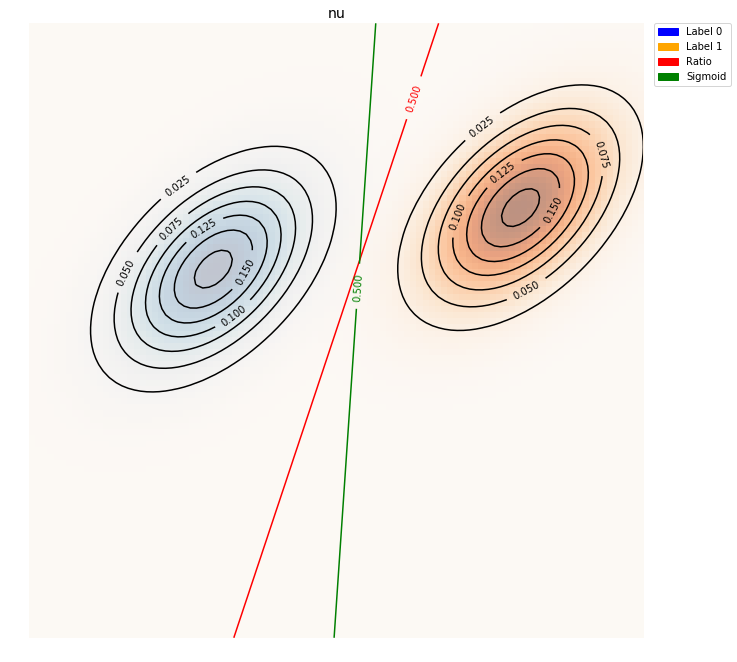

In [59]:
plot_contour(**res, title='nu')